In [1]:
import matplotlib
import sys
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.font_manager as fm
import gseapy as gp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from cmapPy.pandasGEXpress.parse import parse
from scipy import stats
from pandas import DataFrame as df
from matplotlib import pyplot as plt
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Global path

In [2]:
data_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/data/'
gsea_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/GSEA/'

# Data

In [3]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]
print(gene_sets.keys())

dict_keys(['NREC_profile', 'REC_profile'])


In [45]:
# read GSE190266 info
info_190266 = pd.read_csv(data_home + '/GSE190266/GSE190266_series_matrix_subset.txt',
                          index_col=0, header=0, sep='\t').T
print(info_190266)

!Sample_title !Sample_geo_accession               !disease_state  \
A14-118-2                GSM5718805  disease state: non-squamous   
A14-3243-1               GSM5718806  disease state: non-squamous   
A14-4829-2               GSM5718807  disease state: non-squamous   
A15-1673-2               GSM5718808      disease state: squamous   
A15-1759-1               GSM5718809  disease state: non-squamous   
...                             ...                          ...   
A19-5972-1               GSM5718870  disease state: non-squamous   
A19-6764                 GSM5718871  disease state: non-squamous   
A19-718-1                GSM5718872  disease state: non-squamous   
C15-2297                 GSM5718873  disease state: non-squamous   
C15-3437-1               GSM5718874      disease state: squamous   

!Sample_title                  !pfs_time             !pfs_event  
A14-118-2         pfs_time (6 months): 6  pfs_evt (6 months): 0  
A14-3243-1     pfs_time (6 months): 1.53  pfs_evt (

In [46]:
info_190266.columns

Index(['!Sample_geo_accession', '!disease_state', '!pfs_time', '!pfs_event'], dtype='object', name='!Sample_title')

In [47]:
info_190266['!disease_state'].value_counts()

disease state: non-squamous    54
disease state: squamous        14
disease state: 5                1
disease state: NA               1
Name: !disease_state, dtype: int64

In [48]:
info_190266.loc[info_190266[info_190266['!disease_state'] == 'disease state: non-squamous'].index, 'disease_color'] = 'violet'
info_190266.loc[info_190266[info_190266['!disease_state'] == 'disease state: squamous'].index, 'disease_color'] = 'royalblue'

In [19]:
# clean the expression file
with open(data_home + '/GSE190266/GSE190266_TPM_France4_cleaned.csv', 'w') as f_out:
    with open(data_home + '/GSE190266/GSE190266_TPM_France4.csv', 'r') as f:
        for lines in f:
            f_out.write('.'.join(lines.rstrip().split(',')) + '\n')

In [22]:
# read GSE190266 expression
expr_190266 = pd.read_csv(data_home + '/GSE190266/GSE190266_TPM_France4_cleaned.csv',
                          index_col=0, header=0, sep=';').T

In [23]:
expr_190266

,A14-118-2,A14-3243-1,A14-4829-2,A15-1673-2,A15-1759-1,A15-2145-II2,A15-2146-2,A15-2890-2,A15-3549-1,A15-4090-1,...,A19-4598,A19-5029-2,A19-503-2,A19-5242-2,A19-5795-1,A19-5972-1,A19-6764,A19-718-1,C15-2297,C15-3437-1
A1BG,23.871400,23.063600,55.279700,22.407270,35.819600,44.412800,37.224100,30.301250,63.584800,30.04430,...,29.736420,52.11759,53.743010,164.056810,19.925200,54.976800,77.958240,29.293550,49.638000,0.0
A1CF,0.977844,0.000000,0.000000,0.000000,0.848606,0.000000,10.881420,0.399551,0.000000,0.00000,...,0.683820,0.00000,0.513332,11.169120,0.000000,0.000000,0.672599,0.461709,0.846277,0.0
A2M,0.000000,466.492000,30.856700,2431.876900,324.290565,365.814168,89.378010,280.877540,307.268380,57.80890,...,110.491789,463.80662,144.319600,282.303640,0.667144,0.000000,90.285590,408.956692,133.844450,0.0
A2ML1,1.379480,0.000000,0.000000,10.710763,1.617240,0.000000,23.506750,0.000000,2.435190,0.00000,...,2.308190,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.939510,0.0
A2MP1,0.000000,0.000000,0.000000,0.000000,0.000000,1.219610,0.503353,1.747860,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.750132,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MTMR1,1.224612,0.799202,0.000000,1.732494,1.401826,2.613524,3.518568,0.951248,2.626582,0.00000,...,3.808558,3.33014,6.512250,0.000000,0.000000,0.000000,1.178330,3.648079,6.264305,0.0
MTMR10,2.821090,3.212900,1.906121,3.905670,3.662370,6.866540,2.229535,4.735041,1.655730,0.00000,...,5.158410,1.17245,4.899892,1.269150,0.000000,0.000000,0.000000,5.237390,6.018111,0.0
MTMR11,2.503180,0.857201,0.000000,0.459526,5.013070,0.000000,0.000000,0.000000,1.093800,2.25580,...,11.737030,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.543479,0.000000,0.0
MTMR12,117.252700,8.243950,0.000000,8.664640,10.478870,9.139650,7.455520,24.549920,2.101600,3.41828,...,7.969080,2.59735,13.204570,1.247510,0.000000,10.046191,2.787210,2.449930,10.155450,0.0


# NREC and REC expression

In [24]:
nrec_190266 = expr_190266[expr_190266.index.isin(gene_sets['NREC_profile'])]
rec_190266 = expr_190266[expr_190266.index.isin(gene_sets['REC_profile'])]

In [36]:
ec_merged = pd.concat([nrec_190266, rec_190266], axis=0)

In [37]:
ec_merged.shape

(708, 70)

In [43]:
nrec_190266.shape

(610, 70)

In [44]:
rec_190266.shape

(98, 70)

In [53]:
ec_color = df(index=ec_merged.index, columns=['color'])
ec_color.loc[nrec_190266.index, 'color'] = 'crimson'
ec_color.loc[rec_190266.index, 'color'] = 'cornflowerblue'

## 0. all EC expression

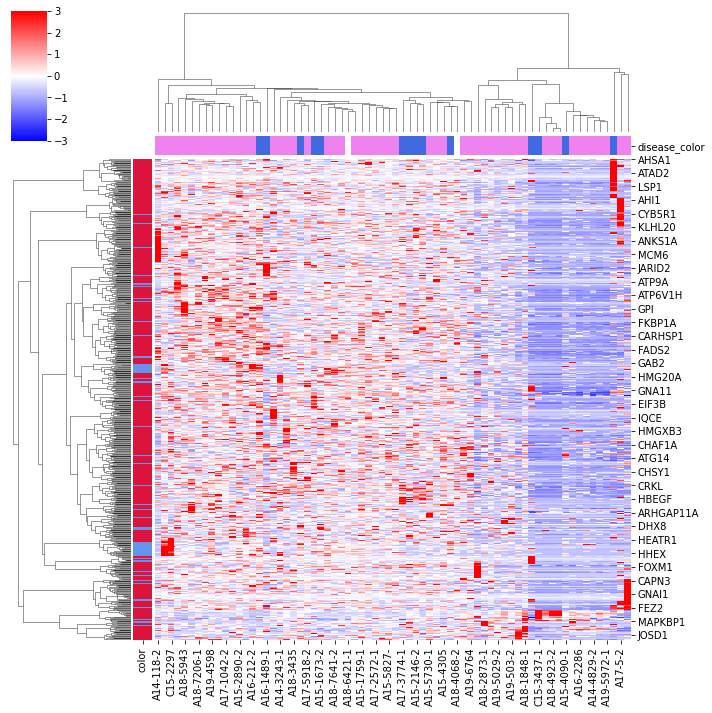

In [57]:
sns.clustermap(ec_merged, z_score=0,
               vmin=-3, vmax=3,
               col_colors=info_190266['disease_color'],
               row_colors=ec_color['color'],
               method='ward', cmap='bwr')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


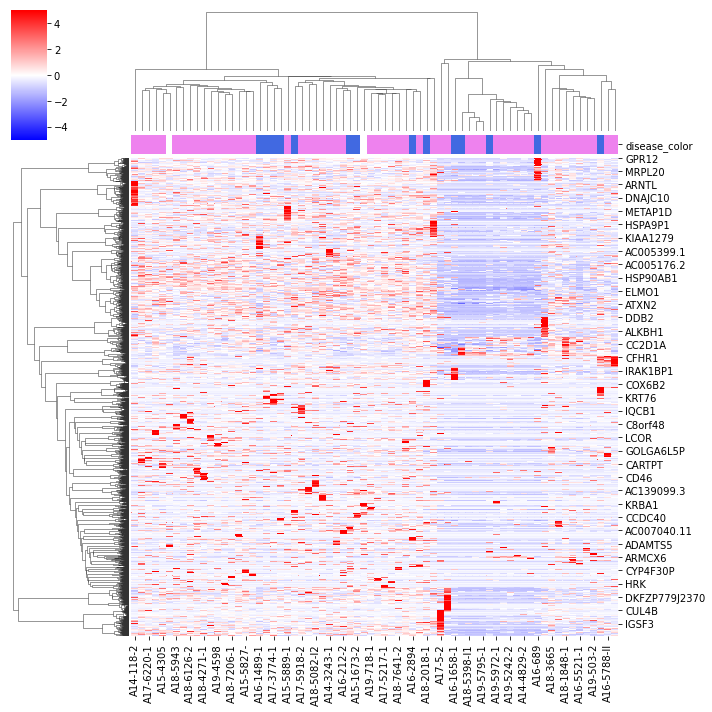

In [50]:
sns.clustermap(expr_190266[expr_190266 > 0].dropna(axis=0, how='all').fillna(0), z_score=0,
               vmin=-5, vmax=5,
               col_colors=info_190266['disease_color'],
               method='ward', cmap='bwr')

## 1. NREC expression

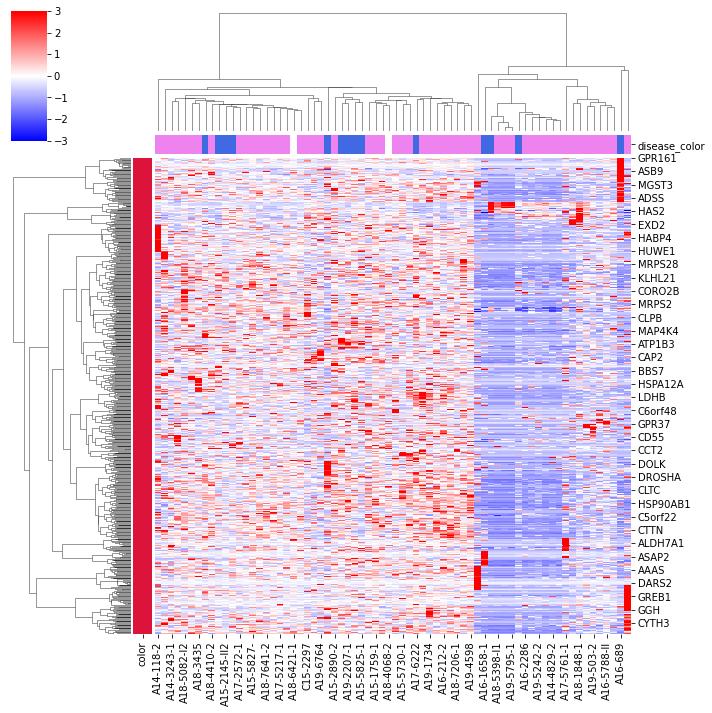

In [58]:
sns.clustermap(nrec_190266, z_score=0,
               vmin=-3, vmax=3,
               col_colors=info_190266['disease_color'],
               row_colors=ec_color['color'],
               method='ward', cmap='bwr')

## 2. REC expression

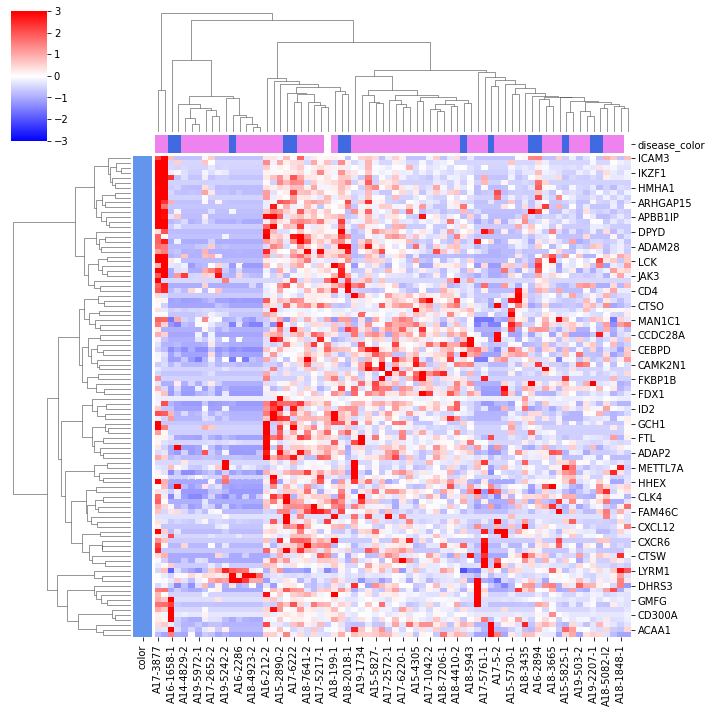

In [59]:
sns.clustermap(rec_190266, z_score=0,
               vmin=-3, vmax=3,
               col_colors=info_190266['disease_color'],
               row_colors=ec_color['color'],
               method='ward', cmap='bwr')